# Estudo de modelos para séries temporais

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.offline as pyo
import plotly.graph_objs as go
pyo.init_notebook_mode(connected=True)

### Leitura dos dados

In [33]:
tserie = pd.read_csv('ribeiroGon.csv', index_col = 0).drop('data_ticks',1)

tserie = tserie[tserie['year'] >= 1988]

tserie['Data'] = pd.date_range('01-01-1988',periods=len(tserie), freq='MS')

tserie = tserie.set_index('Data')

#### Construção de histogramas e diagramas de dispersão

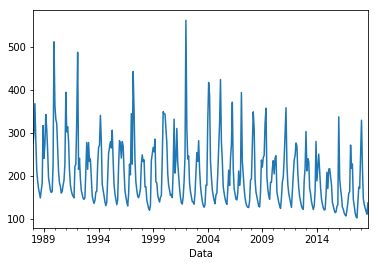

In [36]:
tserie['vazao'].plot()

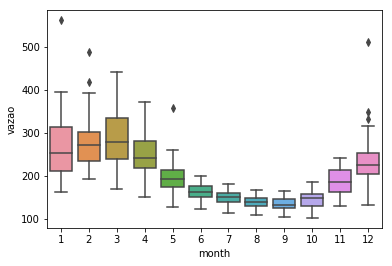

In [35]:
sns.boxplot(x= 'month', y= 'vazao', data = tserie)

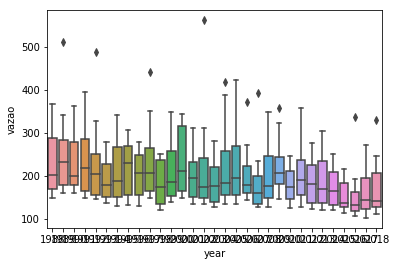

In [38]:
sns.boxplot(x= 'year', y= 'vazao', data = tserie)

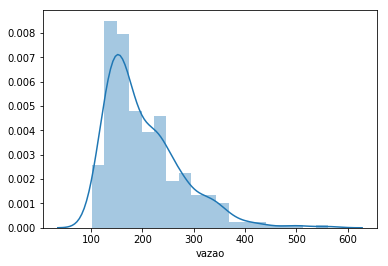

In [59]:
sns.distplot(tserie['vazao'])
plt.show()

#### Decomposição

In [39]:
from statsmodels.tsa.seasonal import seasonal_decompose

/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning:

numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject



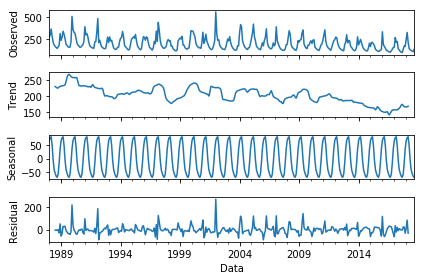

In [41]:
result = seasonal_decompose(tserie['vazao'])
result.plot()
plt.show()

#### ACF e PCF

**Pergunta:** Como analisar estes plots de forma correta?

In [42]:
from pandas.plotting import lag_plot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning:

numpy.ufunc size changed, may indicate binary incompatibility. Expected 216, got 192



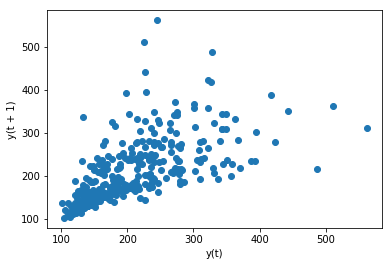

In [43]:
lag_plot(tserie['vazao'], lag=1)

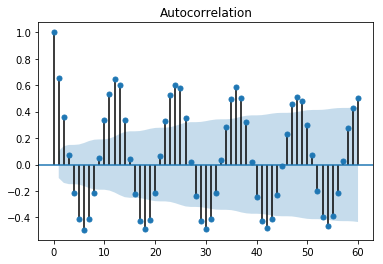

In [49]:
plot_acf(tserie['vazao'], lags = 60)
plt.show()

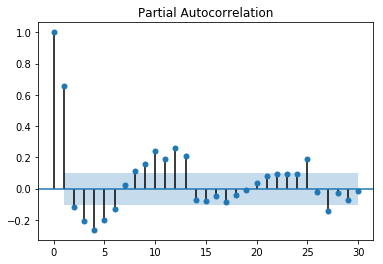

In [52]:
plot_pacf(tserie['vazao'], lags = 30)
plt.show()

#### Análise de estacionariedade

In statistics and econometrics, an [augmented Dickey–Fuller test (ADF)](https://en.wikipedia.org/wiki/Augmented_Dickey%E2%80%93Fuller_test) tests the null hypothesis that a unit root is present in a time series sample.

A função de ACF pode ser utilizada para desvendar se uma série é estacionária ou não. Séries não estacionárias apresentam alta correlação entre os valores para diversos lags. 

**É mais difícil modelarmos séries não estacionárias, pois diferentes intervalos de tempo apresentam diferentes comportamentos.**

In [57]:
from statsmodels.tsa.stattools import adfuller

- Sem diff

In [62]:
result = adfuller(tserie['vazao'].values)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: -2.460416
p-value: 0.125405
Critical Values:
	1%: -3.449
	5%: -2.870
	10%: -2.571


Como p-value > 0.5, nossa hipótese nula foi comprovada (a série não é estacionária). Para torná-la estacionária, fazemos um diff.

- Diff = 1

In [64]:
result = adfuller(tserie['vazao'].diff().dropna().values)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: -15.095605
p-value: 0.000000
Critical Values:
	1%: -3.449
	5%: -2.870
	10%: -2.571


P-value é menor que 0.05! Hipótese nula refutada, portanto a série com uma ordem de integração é estacionária!

# Previsão

Para não enviesar a análise, divisão entre train e test:

In [65]:
train = tserie['vazao'][:-12]
test = tserie['vazao'][-12:]

In [83]:
start = '2017-10-01'
end = '2018-09-01'

## Modelos AR(p) -  autoregressivo

Suponha uma série temporal {$X_1$, $X_2$, ... , $X_n$}. Dizemos que $X_t$ é um processo autorregressivo de ordem $p$ e escrevemos $X_t \sim AR(p)$ se podemos escrever o processo na seguinte forma:

$$X_t = \phi_1X_{t-1} + ... + \phi_pX_{t-p} + \epsilon_t , $$

onde $\phi_1, ...,\phi_p$ são parâmetros reais e $\epsilon_t$ são i.i.d com $E(\epsilon_t) = 0$ e $Var(\epsilon_t) = \sigma^2$.

In [68]:
from statsmodels.tsa.ar_model import AR

In [106]:
# treinando o modelo
model = AR(train, freq='MS')
AR1 = model.fit(maxlag = 1, trend = 'nc')

**Obs:** maxlag aqui é autoregressivo de 1 mes, não vai levar em conta portanto a sazonalidade

In [107]:
print(AR1.k_ar)
print(AR1.params)

1
L1.vazao    0.958297
dtype: float64


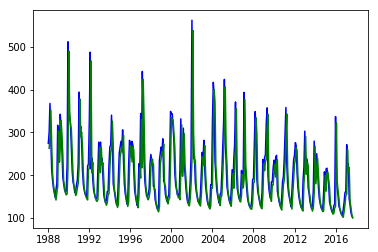

In [72]:
plt.plot(train, color = 'blue')
plt.plot(AR1.fittedvalues, color = 'green')

plt.show()

In [84]:
predictions = AR1.predict(start=start, end = end)

/home/blamassa/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:336: FutureWarning:

Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.



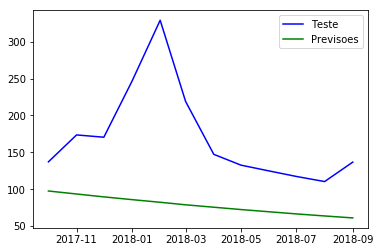

In [86]:
plt.plot(test, color = 'blue', label = 'Teste')
plt.plot(predictions, color = 'green', label = 'Previsoes')
plt.legend()

plt.show()

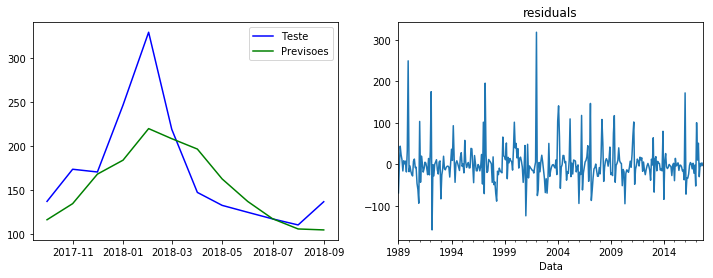

MSE =  1872.2652641690217
MAPE =  18.733328578841046


In [112]:
AR1 = model.fit(maxlag = 12, trend = 'nc')
predictions = AR1.predict(start=start, end = end)

fig, (ax1,ax2) = plt.subplots(1,2, figsize=(12,4))
ax1.plot(test, color = 'blue', label = 'Teste')
ax1.plot(predictions, color = 'green', label = 'Previsoes')
ax1.legend()

residuals = AR1.resid
ax2.set_title('residuals')
residuals.plot(ax = ax2)

plt.show()

mse = sum((predictions - test)**2)/len(predictions)
mape = (100/len(predictions))*sum(abs((predictions - test))/(predictions))

print('MSE = ', mse)
print('MAPE = ', mape)
plt.show()

- Repetindo o processo com a ordem = 1

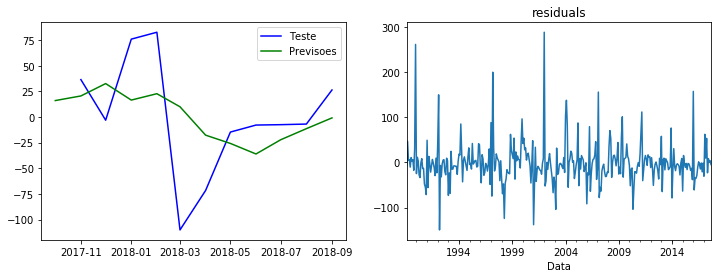

MSE =  2534.99906464127
MAPE =  -146.90045444352836


In [128]:
# treinando o modelo
model = AR(train.diff(1), freq='MS', missing='drop')
AR1 = model.fit(maxlag = 1, trend = 'nc')
AR1 = model.fit(maxlag = 12, trend = 'nc')
predictions = AR1.predict(start=start, end = end)

fig, (ax1,ax2) = plt.subplots(1,2, figsize=(12,4))
ax1.plot(test.diff(1).dropna(), color = 'blue', label = 'Teste')
ax1.plot(predictions, color = 'green', label = 'Previsoes')
ax1.legend()

residuals = AR1.resid
ax2.set_title('residuals')
residuals.plot(ax = ax2)

plt.show()

mse = sum((predictions[1:] - test.diff(1).dropna())**2)/len(predictions[1:])
mape = (100/len(predictions[1:]))*sum(abs((predictions[1:] - test.diff(1).dropna()))/(predictions[1:]))

print('MSE = ', mse)
print('MAPE = ', mape)

## Modelos MA(q) - médias móveis (Moving Average)

Dizemos que $X_t$ é um processo de médias móveis de ordem $q$, denotado por $MA(q)$ se podemos escrever o processo na seguinte forma:

$$X_t = \epsilon_t - \theta_1 \epsilon_{t-1} - ... - \theta_q\epsilon_{t-q},
$$

onde $\theta_1, ..., \theta_q$ são constantes reais e $\epsilon_t$ apresenta as mesmas restrições que para models AR(p).

In [113]:
from statsmodels.tsa.arima_model import ARIMA

In [123]:
model = ARIMA(train, freq = 'MS', order = (0,0,12))
MA = model.fit()

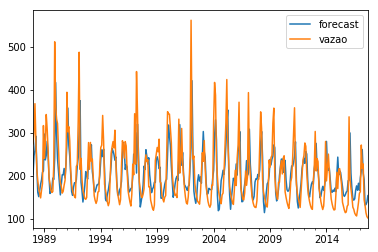

In [124]:
MA.plot_predict()
plt.show()

In [125]:
predictions = MA.forecast(12)
predictions = predictions[0]
predictions

array([162.66746791, 200.29978827, 227.84035325, 227.01839628,
       222.69126336, 207.2738165 , 191.37595237, 177.61115392,
       172.31551997, 177.85604837, 193.14049995, 203.75798309])

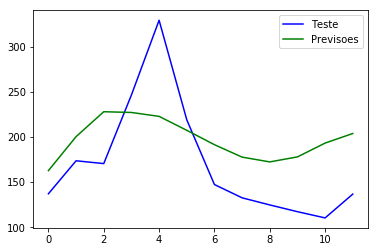

MSE =  3145.9885959617313
MAPE =  25.17235351030596


In [126]:
plt.plot(test.values, color = 'blue', label = 'Teste')
plt.plot(predictions, color = 'green', label = 'Previsoes')
plt.legend()

plt.show()

mse = sum((predictions - test)**2)/len(predictions)
mape = (100/len(predictions))*sum(abs((predictions - test))/(predictions))

print('MSE = ', mse)
print('MAPE = ', mape)

## Comparação modelos AR e MA

- Para processos do tipo AR, escolhemos a ordem $p$ com base na PACF.
- Para processos do tipo MA, scolhemos a ordem $q$ com base na ACF.

**Isso não significa que a ACF não seja importante para modelos do tipo AR ou que a PACF não seja importante para modelos MA.**

| Modelo | ACF | PACF |
| --- | --- | --- |
| MA(1) | 1 pico no lag 1 | Decrescimento exponencial |
| AR(1) | Decrescimento exponencial | 1 pico no lag 1 |
| MA(2) | 1 pico no lag 1 e 1 pico no lag 2 | Ondas senóides amortecidas |
| AR(2) | Ondas senóides amortecidas | 1 pico no lag 1 e 1 pico no lag 2 |
| ARMA(1,1) | Decrescimento exponencial | Decrescimento exponencial |

- MA(q): essencialmente baseado nos termos de erro dos períodos passados;
- MA(q): erros impactam a variável resposta apenas no momento atual e *q* tempos para frente;
- AR(p): erros de tempos anteriores têm impacto indireto no momento atual;
- AR(p): erros afetam a variável infinitamente.

## Modelos ARMA(p,q)